# Introduction
As a part of this notebook, we'll be trying various models on competition organised on https://kelvins.esa.int/proba-v-super-resolution/home/. Competition was organized by european space agency for processing low resolution images and produce one high resolution image. Competiton provides data which are taken on 78 different earth locations. PROBA-V is an ESA satelite which generally takes crops images and one responsible for taking these images. Satelite has captured many 300m low resolution images which needs to be processed to produce high resolution images which can be used for various purpose. Satelite is capable of generating 100m high resolution images but at lower frequency thatn 300m low resolution images and also its costly to produce images with it. Hence ESA has asked us to create Deep Learning models which can combine low resolution images to generate high resolution image. Participants are provided with train data which has many(~16) low resolution images(128x128) per image location and one high resolution image(384x384) for that location. We'll be trying few deep learning models which will combine these 128x128 low resolution images to generate 384x384 high resolution images. Test data has been provided as well for which we'll be predicting images.

We'll be trying 3 different models to generate high resolution image:
1. DCGAN (Deep Convolutional Generative Adversial Networks)
2. Residual Network v1
3. Residual Network v2

### Importing Project Libraries

In [1]:
from PIL import Image
#from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt

import skimage
from skimage import io
from skimage.transform import rescale, resize

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import torch
import torchvision

import os
from collections import Counter
from zipfile import ZipFile
import warnings
warnings.filterwarnings('ignore')


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Processor Type : ', device)
%matplotlib inline

Processor Type :  cuda


### Checking Files in Directories

In [2]:
%ls /kaggle/input/probav-data

norm.csv  test/  train/


In [3]:
%ls /kaggle/input/probav-data/train/RED/imgset0000

HR.png     LR005.png  LR011.png  QM000.png  QM006.png  QM012.png
LR000.png  LR006.png  LR012.png  QM001.png  QM007.png  QM013.png
LR001.png  LR007.png  LR013.png  QM002.png  QM008.png  QM014.png
LR002.png  LR008.png  LR014.png  QM003.png  QM009.png  QM015.png
LR003.png  LR009.png  LR015.png  QM004.png  QM010.png  QM016.png
LR004.png  LR010.png  LR016.png  QM005.png  QM011.png  SM.png


### Reading Sample Images
Below we are reading one sample low resolution image and one high resolution image using scikit-image library for testing purpose.

In [4]:
lr_img = io.imread('/kaggle/input/probav-data/train/NIR/imgset0594/LR002.png')
lr_float = skimage.img_as_float(lr_img)

hr_img = io.imread('/kaggle/input/probav-data/train/NIR/imgset0594/HR.png')
hr_float = skimage.img_as_float(hr_img)

lr_float[:3,:3], hr_float[:3,:3]

(array([[0.15332265, 0.15210193, 0.15063706],
        [0.15063706, 0.14941634, 0.14892805],
        [0.1469749 , 0.1469749 , 0.14551003]]),
 array([[0.15161364, 0.15381094, 0.15454337],
        [0.15283436, 0.15454337, 0.1557641 ],
        [0.15429923, 0.15405509, 0.15429923]]))

### Test Rescale of Image
Below we are plotting one low resolution image after rescaling it.

(384, 384)


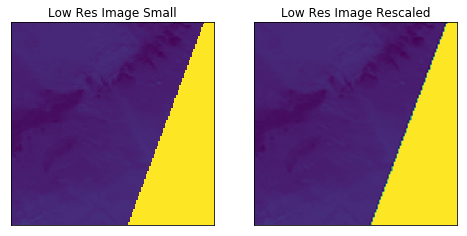

In [5]:
lr_img_rescaled = rescale(lr_float, scale=3, order=3, mode='edge', anti_aliasing=False, multichannel=False)
print(lr_img_rescaled.shape)

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(lr_float)
plt.xticks([],[])
plt.yticks([],[])
plt.title('Low Res Image Small')

plt.subplot(122)
plt.imshow(lr_img_rescaled)
plt.xticks([],[])
plt.yticks([],[])
plt.title('Low Res Image Rescaled');

### Visualizing Sample Images
Below we are visualizing original low resolution image, rescaled low resolution image and high resolution image for comparision purpose.

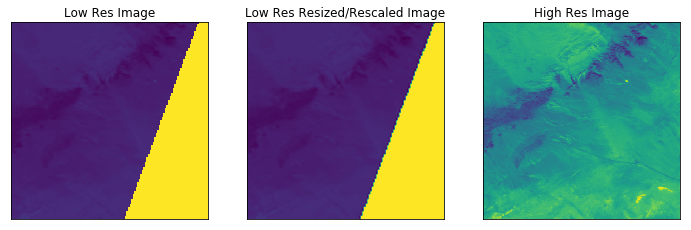

In [6]:
fig = plt.figure(figsize=(12,4))

plt.subplot(131)
plt.imshow(lr_float)
plt.xticks([],[])
plt.yticks([],[])
plt.title('Low Res Image')

plt.subplot(132)
plt.imshow(lr_img_rescaled)
plt.title('Low Res Resized/Rescaled Image')
plt.xticks([],[])
plt.yticks([],[])

plt.subplot(133)
plt.imshow(hr_float);
plt.title('High Res Image')
plt.xticks([],[])
plt.yticks([],[]);

### Helper Method to Get Imageset Names with Full Path

In [7]:
root_dir_train = '/kaggle/input/probav-data/train' ## Root directory where train images are kept. Please change it according to your needs.
root_dir_test = '/kaggle/input/probav-data/test' ## Root directory where test images are kept. Please change it according to your needs.

def return_image_sets_full_path(root_dir):
    """
    param: root_dir : directory where imagesets are kept. 
    return: list of imagesets with full path
    descr: It'll loop through both RED and NIR bands and take into cosideration all imagesets and returns full path for all of them.
    """
    all_image_sets = []
    for typ in ['RED', 'NIR']:
        full_path = os.path.join(root_dir, typ)
        image_sets = os.listdir(full_path)
        image_sets = [os.path.join(full_path, img_set) for img_set in image_sets]
        all_image_sets.extend(image_sets)
    return all_image_sets

train_image_sets = return_image_sets_full_path(root_dir_train) ## Getting all train imagesets
test_image_sets = return_image_sets_full_path(root_dir_test) ## Getting all test imagesets

## Splitting ImageSets into Train/Test Sets
Below we are splitting images into train and validation sets. We'll be keeping 98% of images into train sets and 2% into validation sets.

In [8]:
train_image_sets, val_image_sets = train_test_split(train_image_sets, train_size=0.98, test_size=0.02, random_state=42)

print('Train Image Sets : ', len(train_image_sets))
print('Validation Image Sets : ', len(val_image_sets))
print('Test Image Sets : ', len(test_image_sets))

Train Image Sets :  1136
Validation Image Sets :  24
Test Image Sets :  290


Below method takes as input predicted image and actual image and then generates Peak Signal to Noise Ratio for it.

In [9]:
def cPSNR(predited_image, original_image):
    mse = mean_squared_error(original_image, predited_image)
    cpsnr = -10 * np.log10(mse)
    return cpsnr

# 1. DCGAN Approach
Below we are trying our first approach where we'll be suing DCGAN model. DCGAN model is generally used for generating high resolution images from low resolution images. DGCAN approach has 2 neural networks(Generator & Discriminator).
1. Generator : Generator takes as input low resolution image and tries to generate high resolution image
2. Discriminator : Discriminator predicts whether generator accurately generates high resolution image or not.

We'll be training model for few epochs. 

### Initialized Convolutiona Layers
From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02

**Reference:** https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [10]:
def initialize_weights(layer):
    """
    layer: torch.nn.Layer class.
    descr: initializes weight of layer.
    """
    layer_name = layer.__class__.__name__
    if 'Conv' in layer_name:
        torch.nn.init.normal_(layer.weight.data, mean = 0.0, std = 0.02)
    elif layer_name.find('BatchNorm') != -1:
        torch.nn.init.normal_(layer.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(layer.bias.data, 0)

## Generator
Below is architecture of our Generator Neural network defined. Generator consists of 4 convlution transpose layers followed by batch norm and Relu layers. Model takes a input batch of low resolution images and applies various weights to generate high resolution images.

In [11]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(1, 3, (3,3), padding=1, bias=False),
            torch.nn.ReLU(True),
            
            torch.nn.ConvTranspose2d(3, 6, (3,3), padding=1, bias=False),
            torch.nn.BatchNorm2d(6),
            torch.nn.ReLU(True),
            
            torch.nn.ConvTranspose2d(6, 9, (3,3), padding=1, bias=False),
            torch.nn.BatchNorm2d(9),
            torch.nn.ReLU(True),
            
            torch.nn.ConvTranspose2d(9, 6, (3,3), padding=1, bias=False),
            torch.nn.BatchNorm2d(6),
            torch.nn.ReLU(True),
            
            torch.nn.ConvTranspose2d(6, 3, (3,3), padding=1, bias=False),
            torch.nn.BatchNorm2d(3),
            torch.nn.ReLU(True),
            
            torch.nn.ConvTranspose2d(3, 1, (3,3), padding=1, bias=False),
            torch.nn.Tanh()
        )
    def forward(self, inp):
        return self.model(inp)

### Shape Test of Generator
Below we are checking that whether model generates same batch images as out as it has taken as input.

In [12]:
gen = Generator().to(device)
out = gen(torch.randn(10,1,384,384).to(device))
print('Shape Check : ', out.shape)

Shape Check :  torch.Size([10, 1, 384, 384])


### Initializing Generators

In [13]:
generator = Generator().to(device) ## Initializing genrator and putting it to proper device(cpu or gpu).
generator = generator.apply(initialize_weights)
print(generator)

Generator(
  (model): Sequential(
    (0): ConvTranspose2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): ConvTranspose2d(6, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): BatchNorm2d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): ConvTranspose2d(9, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): ConvTranspose2d(6, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (12): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)


## Discriminator
Below we have defined architecture of discriminator. Discriminator checks whether processed low resolution image matches with hgih resolution image or not. Main task of generator is to confuse discriminator by generating very accurate high resolution images by combining low resolution images. Our discriminator has 7 convolution layers followed by batch norm and relu layers. Last layer of model has sigmoid function which outputs probability of whether processed high resolution matches with actual high resolution image or not.

In [14]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(1, 3, (3,3), stride=2, padding = 1, bias=False),
            torch.nn.ReLU(True),
            
            torch.nn.Conv2d(3,6,(3,3), stride=2, padding = 1, bias = False),
            torch.nn.BatchNorm2d(6),
            torch.nn.ReLU(True),
            
            torch.nn.Conv2d(6,9,(3,3) ,stride=2, padding = 1, bias = False),
            torch.nn.BatchNorm2d(9),
            torch.nn.ReLU(True),
            
            torch.nn.Conv2d(9,6,(3,3), stride=2, padding = 1, bias = False),
            torch.nn.BatchNorm2d(6),
            torch.nn.ReLU(True),
            
            torch.nn.Conv2d(6,3,(3,3), stride=2, padding = 1, bias = False),
            torch.nn.BatchNorm2d(3),
            torch.nn.ReLU(True),
            
            torch.nn.Conv2d(3,2,(3,3), stride=2, padding = 1, bias = False),
            torch.nn.BatchNorm2d(2),
            torch.nn.ReLU(True),
            
            torch.nn.Conv2d(2,1,(6,6), stride=1, padding = 0, bias = False),
            torch.nn.Sigmoid(),
            
        )
    def forward(self, inp):
        return self.model(inp)

### Shape Test Of Discriminator
Testing whether output shape of discriminator is proper or not.

In [15]:
d = Discriminator().to(device)
d(torch.randn(10,1, 384, 384).to(device)).shape

torch.Size([10, 1, 1, 1])

### Initializing Discriminator

In [16]:
discriminator = Discriminator().to(device)
discriminator = discriminator.apply(initialize_weights) ## Initializing weights in discriminator
discriminator

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): Conv2d(3, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(6, 9, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Conv2d(9, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(6, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv2d(3, 2, kernel_size=(3, 3)

## Loss and Optimizers
Below we have initialized loss and optimization function. we'll be using BCELoss for calculating loss which is used for binary classification. We'll be using Adam optimizer for calculating gradients and updating weights of model. We'll be using very low  learning rate of 0.0002 as we don't want to modify image a lot.

In [17]:
loss = torch.nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

optimizer_generator = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

## Defining Helper Methods
Below we have defined 2 helper methods

`create_list_of_low_res_images_to_skip` takes as input imageset path and return list of images for which less than 60% of pixels are correct. We'll be ignoring this kind of images because we have been asked to ignore low res images with less than 60% correct pixels as they don't provide much information.

`create_imageset` takes as input imageset path and list of low resolution images to be ignored. It then returns all low resolution images present in that imageset.

In [18]:
def create_list_of_low_res_images_to_skip(image_set_path):
    """
    image_set_path : path to image set which holds all image for that particular region.
    return: list containing low res images with less than 60% correct pixels.
    """
    low_res_images_to_be_skipped = []
    for img in os.listdir(image_set_path):
        if img.startswith('QM'):
            img_bool = skimage.io.imread(os.path.join(image_set_path,img))
            pixel_count = Counter(img_bool.flatten())
            img_proper_proportion = pixel_count[255] / (128*128)
            if img_proper_proportion < 0.60:
                low_res_images_to_be_skipped.append(img.split('.')[0][2:])
    return low_res_images_to_be_skipped

In [19]:
def create_imageset(image_set_path, low_res_images_to_be_skipped):
    """
    image_set_path: path to image set.
    low_res_images_to_be_skipped: list of low resolution images to be ignored.
    return: list of low resolution image from imageset as floats.
    """
    imageset = []        
    for img in os.listdir(image_set_path):
        if img.startswith('LR') and img.split('.')[0][2:] not in low_res_images_to_be_skipped:
            img_float = skimage.img_as_float(io.imread(os.path.join(image_set_path, img)))
            img_float = skimage.transform.rescale(img_float, scale=3, order=3, mode='edge', anti_aliasing=False, multichannel=False) #resize(img_float, output_shape=(384,384))
            imageset.append(img_float)
        #else:
        #    if img.startswith('LR'):
        #        print('Skipping Image : %s'%os.path.join(image_set_path, img))
    return imageset

## Training
Training consists of looping through all train imagesets for few epoch and predicting images for validation image sets for each epochs and plotting them as well.

================================================== Epoch : 1 ==================================================

Number of Imageset processed : 100/1136
Error of Generator after imagesets 100 are processed is 0.61801
Error of Discriminator affter imagesets 100 are processed is 1.09567
Number of Imageset processed : 200/1136
Error of Generator after imagesets 200 are processed is 0.44155
Error of Discriminator affter imagesets 200 are processed is 0.73905
Number of Imageset processed : 300/1136
Error of Generator after imagesets 300 are processed is 0.32990
Error of Discriminator affter imagesets 300 are processed is 0.48931
Number of Imageset processed : 400/1136
Error of Generator after imagesets 400 are processed is 0.25659
Error of Discriminator affter imagesets 400 are processed is 0.36002
imgset0545  : Low Res Images to be skipped :  ['006', '007', '000']
Number of Imageset processed : 500/1136
Error of Generator after imagesets 500 are processed is 0.15038
Error of Discriminator 

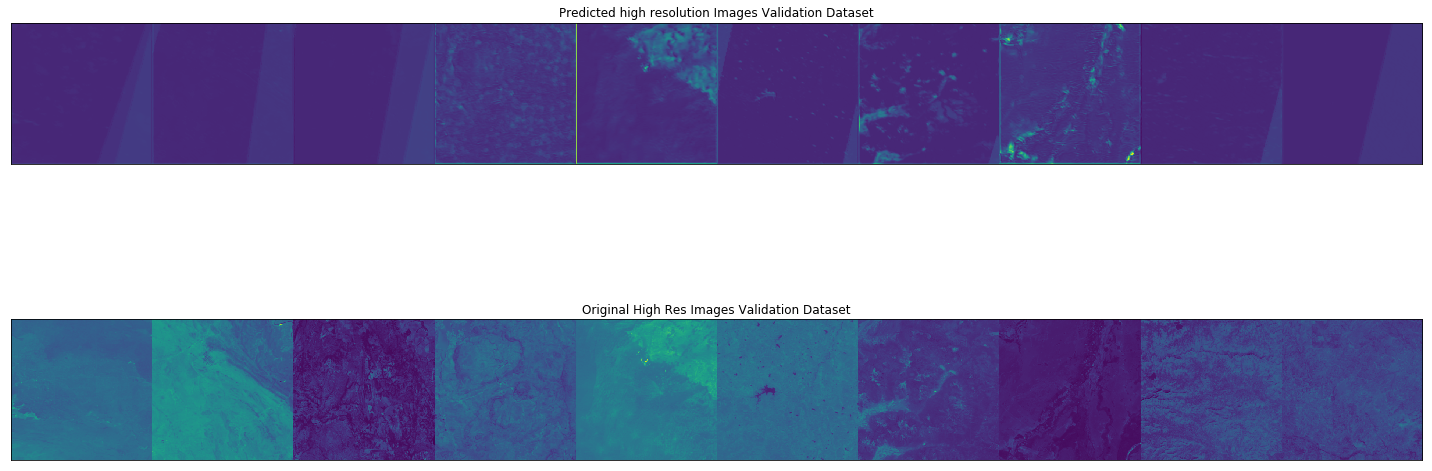

In [20]:
%%time

for epoch in range(1,2): ## Trying of epochs
    print('='*50, 'Epoch : %d'%epoch, '='*50)
    print()
    
    for k, image_set_path in enumerate(train_image_sets, start=1): ### We loop through all imageset of train imageset.
        high_res_img_map = skimage.io.imread(os.path.join(image_set_path,'SM.png')) ## Reading image map for high resolution image
        hr_pixel_count = Counter(high_res_img_map.flatten()) ## Counting correct/incorrect pixel count
        img_proper_proportion = hr_pixel_count[255] / (128*128) ## Correct pixel proportion
        if img_proper_proportion < 0.75: ## We ignore imageset if high resolution image has less than 75% correct pixels.
            print('Skipping Imageset : %s due to low information in high resolution image(less than 75%).'%image_set_path)
            continue
        
        ## Getting list of low res images to be ignored.
        low_res_images_to_be_skipped = create_list_of_low_res_images_to_skip(image_set_path)
        
        if low_res_images_to_be_skipped:
            print(image_set_path.split('/')[-1], ' : Low Res Images to be skipped : ', low_res_images_to_be_skipped)       
            
        ## Getting imagesets
        imageset = create_imageset(image_set_path, low_res_images_to_be_skipped)
        
        lr_batch = np.stack(imageset, axis=0) ## Comining all images of one imageset into one array/
        #print(imageset_batch.shape)
        hr_img = io.imread(os.path.join(image_set_path, 'HR.png')) 
        hr_float = skimage.img_as_float(hr_img)
        hr_batch = np.repeat(hr_float.reshape(1,384,384), lr_batch.shape[0] , axis=0) ## Replicating high resolution image as same number of time as low res.
        
        lr_batch = lr_batch.reshape(lr_batch.shape[0], 1, 384, 384).astype(np.float32)
        hr_batch = hr_batch.reshape(hr_batch.shape[0], 1, 384, 384).astype(np.float32)
        
        lr_batch = torch.from_numpy(lr_batch).to(device) ## Creating tensor from numpy array.
        hr_batch = torch.from_numpy(hr_batch).to(device) ## Creating tensor from numpy array.
        
        #print(lr_batch.shape, hr_batch.shape)
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        
        discriminator.zero_grad()
        real_labels = torch.full((hr_batch.shape[0], ), real_label, device=device)
        # Forward pass real batch of high resolution images through D
        real_output = discriminator(hr_batch).view(-1)
        # Calculate loss on all-real batch
        err_dis_real = loss(real_output, real_labels)
        # Calculate gradients for D in backward pass
        err_dis_real.backward()
        D_x = real_output.mean().item()
        
        ## Train with low resolution images
        fake_output = generator(lr_batch)
        fake_labels = torch.full((hr_batch.shape[0], ), fake_label, device=device)
        # Generate high res image batch with G
        fake_output = discriminator(fake_output).view(-1)
        # Classify all procssed high res images batch with D
        err_dis_fake = loss(fake_output, fake_labels)
        err_dis_fake.backward()
        
        D_G_z1 = fake_output.mean().item()
        errD = err_dis_real + err_dis_fake
        #print(errD)
        optimizer_discriminator.step()
        
        #####################################################
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        generator.zero_grad()
        real_labels = torch.full((hr_batch.shape[0], ), real_label, device=device)
        real_output = discriminator(lr_batch).view(-1)
        err_gen = loss(real_output, real_labels)
        err_gen.backward()
        #print(err_gen)
        D_G_z2 = real_output.mean().item()
        
        optimizer_generator.step()
        
        if k%100 == 0: ## We check progress at every 100 imagesets. We print both neural nets error rates.
            print('='*100)
            print('Number of Imageset processed : %d/%d'%(k, len(train_image_sets)))
            print('Error of Generator after imagesets %d are processed is %.5f'%(k, err_gen))
            print('Error of Discriminator affter imagesets %d are processed is %.5f'%(k, errD))
            print('='*100)
        
    print('='*100)    
    print('Error of Generator after epoch %d, is %.5f'%(epoch, err_gen))
    print('Error of Discriminator after epoch %d, is %.5f'%(epoch, errD))
    print('='*100)
    
    ### Below we are checking performance of trained generator on validation images
    #### We'll generate high resolution images from low resoltion validation image sets.
    ## We'll be plotting processed images and actual high resolution images as well.
    with torch.no_grad():
        print('='*30, 'Checking Performance On Validataion Data', '='*30)
        print()
        predicted_images, high_res_images, cpsnrs = [], [], []
        
        for k, image_set_path in enumerate(val_image_sets): ## Looping through validation imageset.
            low_res_images_to_be_skipped = create_list_of_low_res_images_to_skip(image_set_path)
            imageset = create_imageset(image_set_path, low_res_images_to_be_skipped)
            lr_batch = np.stack(imageset, axis=0) ## Stacking all low res images to create a batch
            lr_batch = lr_batch.reshape(lr_batch.shape[0], 1, 384, 384).astype(np.float32) 
            lr_batch = torch.from_numpy(lr_batch).to(device) ## Creating tensor from numpy array.
            
            hr_img = io.imread(os.path.join(image_set_path, 'HR.png'))
            hr_float = skimage.img_as_float(hr_img)
            
            generator_output = generator(lr_batch).cpu().detach().numpy() ### Processing images.
            predicted_image = generator_output.squeeze().mean(axis=0) ## Generating high res image from low res images by doing average of all preds.
            
            high_res_images.append(hr_float)
            predicted_images.append(predicted_image)
            cpsnrs.append(cPSNR(predicted_image, hr_float)) ## Recording CPSNR.
            
        print('Average cPSNR on Validation Dataset : %.5f'%np.array(cpsnrs).mean())
            
        plt.figure(figsize=(20,10))
        plt.subplot(211)
        plt.imshow(np.concatenate(predicted_images[:10], axis=1))
        plt.xticks([],[])
        plt.yticks([],[])
        plt.title('Predicted high resolution Images Validation Dataset')
        plt.subplot(212)
        plt.imshow(np.concatenate(high_res_images[:10], axis=1))
        plt.title('Original High Res Images Validation Dataset')
        plt.xticks([],[])
        plt.yticks([],[])
        plt.tight_layout()

## Test Set Predictions
Below we are using above trained model to do predictions on test imagesets. We'll be generating high res images from low res images for all imagesets and record them.

In [21]:
%%time

with torch.no_grad():
    predicted_images = []

    for k, image_set_path in enumerate(test_image_sets): ## Lopping through test image set.
        low_res_images_to_be_skipped = create_list_of_low_res_images_to_skip(image_set_path)
        imageset = create_imageset(image_set_path, low_res_images_to_be_skipped)
        lr_batch = np.stack(imageset, axis=0)
        lr_batch = lr_batch.reshape(lr_batch.shape[0], 1, 384, 384).astype(np.float32)
        lr_batch = torch.from_numpy(lr_batch).to(device)

        generator_output = generator(lr_batch).cpu().detach().numpy()
        predicted_image = generator_output.squeeze().mean(axis=0)

        predicted_images.append(predicted_image)

CPU times: user 4min 4s, sys: 2min 21s, total: 6min 25s
Wall time: 3min 49s


### Visualizing First Few Predicted Images

Text(0.5, 1.0, 'Predicted high resolution Images Test Dataset')

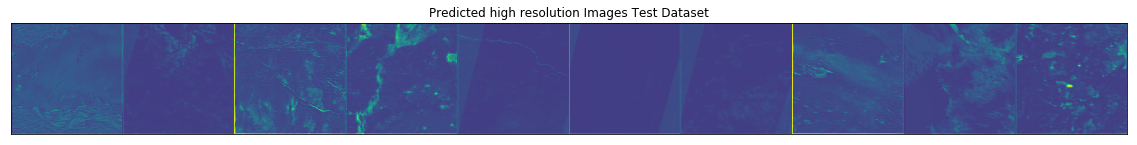

In [22]:
plt.figure(figsize=(20,10))
plt.imshow(np.concatenate(predicted_images[:10], axis=1))
plt.xticks([],[])
plt.yticks([],[])
plt.title('Predicted high resolution Images Test Dataset')

### Saving Predicted Images
Below we are saving all predicted images as png image of unsigned integer of 16 bit so that we can submit it to competition submission.

In [23]:
if not os.path.exists('predicted_images'):
    os.makedirs('predicted_images')
for image_name, image in zip(test_image_sets, predicted_images):
    io.imsave(os.path.join('predicted_images', image_name.split('/')[-1]+'.png'), skimage.img_as_uint(image))

### Zipping Images
Below logic creates zip file out of all predicted high resolution images from test image sets.

In [24]:
print('Archiving: ')
sub_archive = 'submission_dcgan.zip'
zf = ZipFile(sub_archive, mode='w')
try:
    for img in os.listdir('predicted_images'):
        # ignore the .zip-file itself
        if not img.startswith('imgset'):
            continue
        zf.write('predicted_images/' + img, arcname=img)
        print('*', end='', flush='True')
finally:
    zf.close()

Archiving: 
**************************************************************************************************************************************************************************************************************************************************************************************************

Creating link so that file can be downloaded.

In [25]:
from IPython.display import FileLink
FileLink('submission_dcgan.zip')

/kaggle/working/submission_dcgan.zip

# 2. CNN Approach with Residual Blocks
Below we have created our Convolution neural network based on concept of residual block. Residual block is block of few convlution layers output of which is getting added to original input hence called residual blocks. We have first defined ResidualBlock class which defines one residual block of 2 conv layers and followed by PRelu layers. Forward pass through one residual block pass input through conv layers and adds output to original input hence keeping original input intact as much as possible. Our main architecure class is CNNWithResBlocks which consists of 9 such residual blocks followed by 2 conv layers. Last convolution layer of model is followed by ReLU to get output as positive.

In [26]:
class ResidualBlock(torch.nn.Module):
    def __init__(self, channel_size=1, kernel_size=3):
        super(ResidualBlock, self).__init__()
        self.block = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3,3), stride=1, padding=1),
            torch.nn.PReLU(),
            torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3,3), stride=1, padding=1),
            torch.nn.PReLU()
        )

    def forward(self, x):
        residual = self.block(x)
        return x + residual

class CNNWithResBlocks(torch.nn.Module):
    def __init__(self):
        super(CNNWithResBlocks, self).__init__()
        res_layers = [ResidualBlock(1, 3) for _ in range(9)]
        self.res_layers = torch.nn.Sequential(*res_layers)
        self.block = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3,3), stride=1, padding=1),
            torch.nn.PReLU(),
            torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3,3), stride=1, padding=1),
            torch.nn.Tanh()
        )
    
    def forward(self, x):
        x = self.res_layers(x)
        x = self.block(x)
        #x = torch.clamp(x, min=0, max=1)
        return x 

### Shape Test Of NN
Checking that output generated by model is in proper shape.

In [27]:
resnet = CNNWithResBlocks().to(device)
out = resnet(torch.randn(10,1, 384, 384).to(device))
out.shape

torch.Size([10, 1, 384, 384])

### Initializing Residual NN

In [28]:
resnet = CNNWithResBlocks().to(device)
resnet

CNNWithResBlocks(
  (res_layers): Sequential(
    (0): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): PReLU(num_parameters=1)
        (2): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): PReLU(num_parameters=1)
      )
    )
    (1): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): PReLU(num_parameters=1)
        (2): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): PReLU(num_parameters=1)
      )
    )
    (2): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): PReLU(num_parameters=1)
        (2): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): PReLU(num_parameters=1)
      )
    )
    (3): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(1, 1

### Initializing Loss and Optimizer
Below we are initializing loss function and optimizer. we'll be using mean squared error loss function which will be used to reduce difference between generated high res image and actual high res image. We are using Adam optimizer for out purpose with very low learning rate of 0.0002 so that it does not modify images a lot and keep much of original futures intact.

In [29]:
loss = torch.nn.MSELoss()

optimizer = torch.optim.Adam(resnet.parameters(), lr=0.0002, betas=(0.5, 0.999))

## Training
Training consists of looping through all train imagesets for few epoch and predicting images for validation image sets for each epochs and plotting them as well.

================================================== Epoch : 1 ==================================================

Number of Imageset processed : 100/1136
Error of Neural Net after 100 imagesets are processed is 0.03104
Number of Imageset processed : 200/1136
Error of Neural Net after 200 imagesets are processed is 0.01198
Number of Imageset processed : 300/1136
Error of Neural Net after 300 imagesets are processed is 0.01756
Number of Imageset processed : 400/1136
Error of Neural Net after 400 imagesets are processed is 0.00311
imgset0545  : Low Res Images to be skipped :  ['006', '007', '000']
Number of Imageset processed : 500/1136
Error of Neural Net after 500 imagesets are processed is 0.00028
Number of Imageset processed : 600/1136
Error of Neural Net after 600 imagesets are processed is 0.00372
imgset0031  : Low Res Images to be skipped :  ['005', '007', '000']
Number of Imageset processed : 700/1136
Error of Neural Net after 700 imagesets are processed is 0.00052
Number of Images

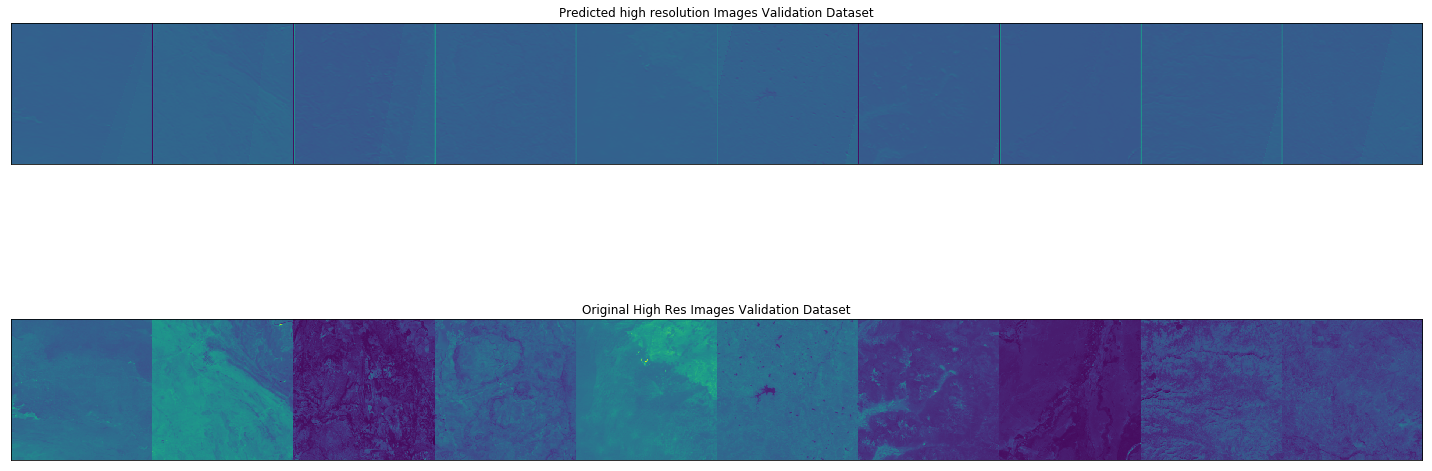

In [30]:
%%time

for epoch in range(1,2):
    print('='*50, 'Epoch : %d'%epoch, '='*50)
    print()
    for k, image_set_path in enumerate(train_image_sets, start=1):
        high_res_img_map = skimage.io.imread(os.path.join(image_set_path,'SM.png'))
        hr_pixel_count = Counter(high_res_img_map.flatten())
        img_proper_proportion = hr_pixel_count[255] / (128*128)
        if img_proper_proportion < 0.75:
            print('Skipping Imageset : %s due to low information in high resolution image(less than 75%).'%image_set_path)
            continue
        
        low_res_images_to_be_skipped = create_list_of_low_res_images_to_skip(image_set_path)
        
        if low_res_images_to_be_skipped:
            print(image_set_path.split('/')[-1], ' : Low Res Images to be skipped : ', low_res_images_to_be_skipped)       
            
        imageset = create_imageset(image_set_path, low_res_images_to_be_skipped)
        
        lr_batch = np.stack(imageset, axis=0)
        #print(imageset_batch.shape)
        hr_img = io.imread(os.path.join(image_set_path, 'HR.png'))
        hr_float = skimage.img_as_float(hr_img)
        hr_batch = np.repeat(hr_float.reshape(1,384,384), lr_batch.shape[0] , axis=0)
        
        lr_batch = lr_batch.reshape(lr_batch.shape[0], 1, 384, 384).astype(np.float32)
        hr_batch = hr_batch.reshape(hr_batch.shape[0], 1, 384, 384).astype(np.float32)
        
        lr_batch = torch.from_numpy(lr_batch).to(device)
        hr_batch = torch.from_numpy(hr_batch).to(device)
        
        #print(lr_batch.shape, hr_batch.shape)
        ## initialize all gradients to zero
        resnet.zero_grad()
        processed_images = resnet(lr_batch) ## Call model to predict image
        
        error = loss(processed_images, hr_batch) ## Call loss function to calculate loss
        error.backward() ## Calling loss backward to calculate gradients for all weights
        
        optimizer.step() ## Calling optimizer to update all weights using gradients.
        
        #####################################################
        
        if k%100 == 0:
            print('='*100)
            print('Number of Imageset processed : %d/%d'%(k, len(train_image_sets)))
            print('Error of Neural Net after %d imagesets are processed is %.5f'%(k, error))
            print('='*100)
        
    print('='*100)    
    print('Error of Neural Net after %d imagesets are processed is %.5f'%(k, error))
    print('='*100)
    
    with torch.no_grad():
        print('='*30, 'Checking Performance On Validataion Data', '='*30)
        print()
        predicted_images, high_res_images, cpsnrs = [], [], []
        
        for k, image_set_path in enumerate(val_image_sets):
            low_res_images_to_be_skipped = create_list_of_low_res_images_to_skip(image_set_path)
            imageset = create_imageset(image_set_path, low_res_images_to_be_skipped)
            lr_batch = np.stack(imageset, axis=0)
            lr_batch = lr_batch.reshape(lr_batch.shape[0], 1, 384, 384).astype(np.float32)
            lr_batch = torch.from_numpy(lr_batch).to(device)
            
            hr_img = io.imread(os.path.join(image_set_path, 'HR.png'))
            hr_float = skimage.img_as_float(hr_img)
            
            preds = resnet(lr_batch).cpu().detach().numpy()
            predicted_image = preds.squeeze().mean(axis=0)
            
            high_res_images.append(hr_float)
            predicted_images.append(predicted_image)
            cpsnrs.append(cPSNR(predicted_image, hr_float))
            
        print('Average cPSNR on Validation Dataset : %.5f'%np.array(cpsnrs).mean())
            
        plt.figure(figsize=(20,10))
        plt.subplot(211)
        plt.imshow(np.concatenate(predicted_images[:10], axis=1))
        plt.xticks([],[])
        plt.yticks([],[])
        plt.title('Predicted high resolution Images Validation Dataset')
        plt.subplot(212)
        plt.imshow(np.concatenate(high_res_images[:10], axis=1))
        plt.title('Original High Res Images Validation Dataset')
        plt.xticks([],[])
        plt.yticks([],[])
        plt.tight_layout()

## Test Set Predictions
Below we are using above trained model to do predictions on test imagesets. We'll be generating high res images from low res images for all imagesets and record them.

In [31]:
%%time

with torch.no_grad():
    predicted_images = []

    for k, image_set_path in enumerate(test_image_sets):
        low_res_images_to_be_skipped = create_list_of_low_res_images_to_skip(image_set_path)
        imageset = create_imageset(image_set_path, low_res_images_to_be_skipped)
        lr_batch = np.stack(imageset, axis=0)
        lr_batch = lr_batch.reshape(lr_batch.shape[0], 1, 384, 384).astype(np.float32)
        lr_batch = torch.from_numpy(lr_batch).to(device)

        processed_images = resnet(lr_batch).cpu().detach().numpy()
        predicted_image = processed_images.squeeze().mean(axis=0)

        predicted_images.append(predicted_image)

CPU times: user 3min 59s, sys: 2min 9s, total: 6min 8s
Wall time: 3min 28s


### Visualizing First Few Predictions

Text(0.5, 1.0, 'Predicted high resolution Images Test Dataset')

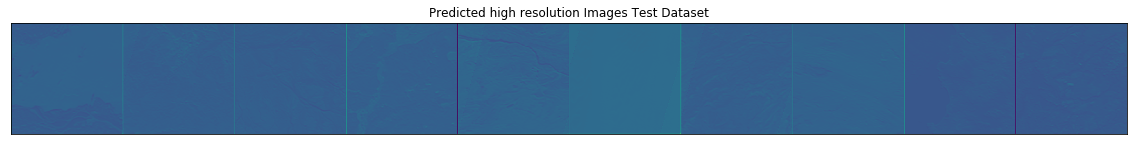

In [32]:
plt.figure(figsize=(20,10))
plt.imshow(np.concatenate(predicted_images[:10], axis=1))
plt.xticks([],[])
plt.yticks([],[])
plt.title('Predicted high resolution Images Test Dataset')

### Saving Predicted Images
Below we are saving all predicted images as png image of unsigned integer of 16 bit so that we can submit it to competition submission.

In [33]:
if not os.path.exists('predicted_images'):
    os.makedirs('predicted_images')
for image_name, image in zip(test_image_sets, predicted_images):
    io.imsave(os.path.join('predicted_images', image_name.split('/')[-1]+'.png'), skimage.img_as_uint(image))

### Zipping Images
Below logic creates zip file out of all predicted high resolution images from test image sets.

In [34]:
print('Archiving: ')
sub_archive = 'submission_resnetv1.zip'
zf = ZipFile(sub_archive, mode='w')
try:
    for img in os.listdir('predicted_images'):
        # ignore the .zip-file itself
        if not img.startswith('imgset'):
            continue
        zf.write('predicted_images/' + img, arcname=img)
        print('*', end='', flush='True')
finally:
    zf.close()

Archiving: 
**************************************************************************************************************************************************************************************************************************************************************************************************

In [35]:
from IPython.display import FileLink
FileLink('submission_resnetv1.zip')

/kaggle/working/submission_resnetv1.zip

# 3. CNN Approach with Residual Blocks v2
Below we are trying another vesion of CNN with residual block. Here we are introducing residual blocks followed by convolution block which increases channels of original image from 1 to 128. It then uses convolution transpose layer to transfer 128 channel image to again 1 channel image.

In [36]:
class ResidualBlock(torch.nn.Module):
    def __init__(self, in_size=1, out_size=1, kernel_size=3):
        super(ResidualBlock, self).__init__()
        self.block = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=in_size, out_channels=in_size, kernel_size=(3,3), stride=1, padding=1),
            torch.nn.PReLU(),
            torch.nn.Conv2d(in_channels=in_size, out_channels=in_size, kernel_size=(3,3), stride=1, padding=1),
            torch.nn.PReLU()
        )
        
        self.conv_block = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=in_size, out_channels=out_size, kernel_size=(3,3), stride=1, padding=1),
            torch.nn.PReLU(),
        )
        
    def forward(self, x):
        residual = self.block(x)
        x =  x + residual
        return self.conv_block(x)

class CNNWithResBlocksv2(torch.nn.Module):
    def __init__(self):
        super(CNNWithResBlocksv2, self).__init__()
        res_layers = [ResidualBlock(1, 4) , ResidualBlock(4, 8), ResidualBlock(8, 16), ResidualBlock(16, 32), ]
        self.res_layers = torch.nn.Sequential(*res_layers)
        self.deconv = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(32, 1, (3,3), stride=1, padding=1),
            torch.nn.Tanh()
        )
    
    def forward(self, x):
        x = self.res_layers(x)
        x = self.deconv(x)
        #x = torch.clamp(x, min=0, max=1)
        return x

### Shape Test for NN

In [37]:
resnet = CNNWithResBlocksv2().to(device)
out = resnet(torch.randn(10,1, 384, 384).to(device))
out.shape

torch.Size([10, 1, 384, 384])

## Initializing ResNetv2

In [38]:
resnet = CNNWithResBlocksv2().to(device)
resnet

CNNWithResBlocksv2(
  (res_layers): Sequential(
    (0): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): PReLU(num_parameters=1)
        (2): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): PReLU(num_parameters=1)
      )
      (conv_block): Sequential(
        (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): PReLU(num_parameters=1)
      )
    )
    (1): ResidualBlock(
      (block): Sequential(
        (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): PReLU(num_parameters=1)
        (2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): PReLU(num_parameters=1)
      )
      (conv_block): Sequential(
        (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): PReLU(num_parameters=1)
      )
    )
    (2): ResidualBlock(
      (block): Sequential(
       

### Initializing Loss and Optimizer
Below we are initializing loss function and optimizer. we'll be using mean squared error loss function which will be used to reduce difference between generated high res image and actual high res image. We are using Adam optimizer for out purpose with very low learning rate of 0.0002 so that it does not modify images a lot and keep much of original futures intact.

In [39]:
loss = torch.nn.MSELoss()

optimizer = torch.optim.Adam(resnet.parameters(), lr=0.0002, betas=(0.5, 0.999))

## Training
Training consists of looping through all train imagesets for few epoch and predicting images for validation image sets for each epochs and plotting them as well.

================================================== Epoch : 1 ==================================================

Number of Imageset processed : 100/1136
Error of Neural Net after 100 imagesets are processed is 0.00189
Number of Imageset processed : 200/1136
Error of Neural Net after 200 imagesets are processed is 0.00102
Number of Imageset processed : 300/1136
Error of Neural Net after 300 imagesets are processed is 0.00343
Number of Imageset processed : 400/1136
Error of Neural Net after 400 imagesets are processed is 0.00140
imgset0545  : Low Res Images to be skipped :  ['006', '007', '000']
Number of Imageset processed : 500/1136
Error of Neural Net after 500 imagesets are processed is 0.00023
Number of Imageset processed : 600/1136
Error of Neural Net after 600 imagesets are processed is 0.00031
imgset0031  : Low Res Images to be skipped :  ['005', '007', '000']
Number of Imageset processed : 700/1136
Error of Neural Net after 700 imagesets are processed is 0.00030
Number of Images

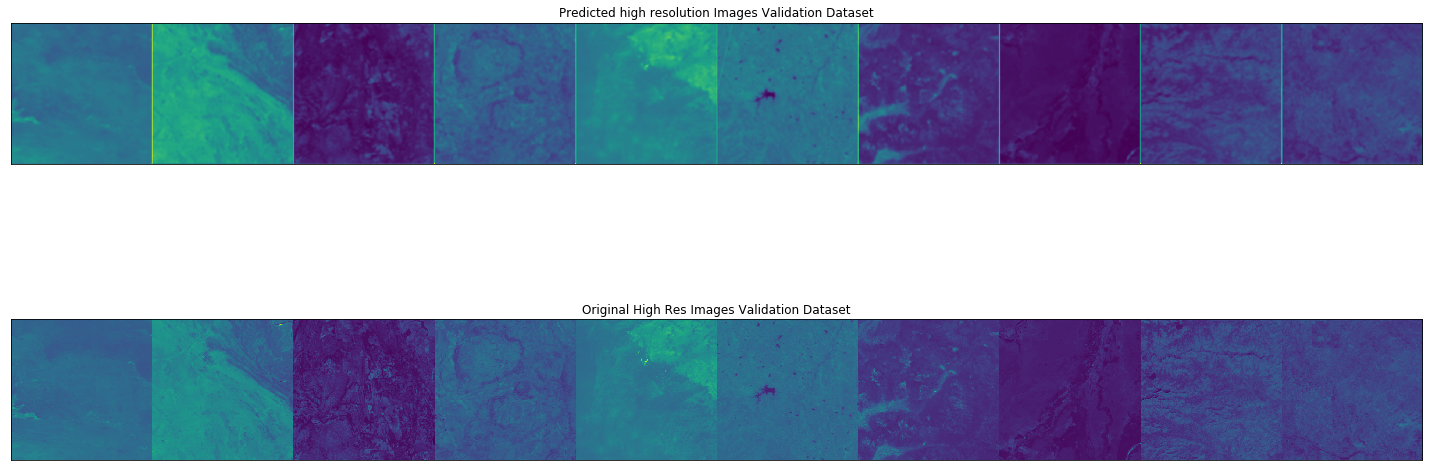

In [40]:
%%time

for epoch in range(1,2):
    print('='*50, 'Epoch : %d'%epoch, '='*50)
    print()
    for k, image_set_path in enumerate(train_image_sets, start=1):
        high_res_img_map = skimage.io.imread(os.path.join(image_set_path,'SM.png'))
        hr_pixel_count = Counter(high_res_img_map.flatten())
        img_proper_proportion = hr_pixel_count[255] / (128*128)
        if img_proper_proportion < 0.75:
            print('Skipping Imageset : %s due to low information in high resolution image(less than 75%).'%image_set_path)
            continue
        
        low_res_images_to_be_skipped = create_list_of_low_res_images_to_skip(image_set_path)
        
        if low_res_images_to_be_skipped:
            print(image_set_path.split('/')[-1], ' : Low Res Images to be skipped : ', low_res_images_to_be_skipped)       
            
        imageset = create_imageset(image_set_path, low_res_images_to_be_skipped)
        
        lr_batch = np.stack(imageset, axis=0)
        #print(imageset_batch.shape)
        hr_img = io.imread(os.path.join(image_set_path, 'HR.png'))
        hr_float = skimage.img_as_float(hr_img)
        hr_batch = np.repeat(hr_float.reshape(1,384,384), lr_batch.shape[0] , axis=0)
        
        lr_batch = lr_batch.reshape(lr_batch.shape[0], 1, 384, 384).astype(np.float32)
        hr_batch = hr_batch.reshape(hr_batch.shape[0], 1, 384, 384).astype(np.float32)
        
        lr_batch = torch.from_numpy(lr_batch).to(device)
        hr_batch = torch.from_numpy(hr_batch).to(device)
        
        #print(lr_batch.shape, hr_batch.shape)
        
        resnet.zero_grad()
        processed_images = resnet(lr_batch)
        
        error = loss(processed_images, hr_batch)
        error.backward()
        
        optimizer.step()
        
        #####################################################
        
        if k%100 == 0:
            print('='*100)
            print('Number of Imageset processed : %d/%d'%(k, len(train_image_sets)))
            print('Error of Neural Net after %d imagesets are processed is %.5f'%(k, error))
            print('='*100)
        
    print('='*100)    
    print('Error of Neural Net after %d imagesets are processed is %.5f'%(k, error))
    print('='*100)
    
    with torch.no_grad():
        print('='*30, 'Checking Performance On Validataion Data', '='*30)
        print()
        predicted_images, high_res_images, cpsnrs = [], [], []
        
        for k, image_set_path in enumerate(val_image_sets):
            low_res_images_to_be_skipped = create_list_of_low_res_images_to_skip(image_set_path)
            imageset = create_imageset(image_set_path, low_res_images_to_be_skipped)
            lr_batch = np.stack(imageset, axis=0)
            lr_batch = lr_batch.reshape(lr_batch.shape[0], 1, 384, 384).astype(np.float32)
            lr_batch = torch.from_numpy(lr_batch).to(device)
            
            hr_img = io.imread(os.path.join(image_set_path, 'HR.png'))
            hr_float = skimage.img_as_float(hr_img)
            
            preds = resnet(lr_batch).cpu().detach().numpy()
            predicted_image = preds.squeeze().mean(axis=0)
            
            high_res_images.append(hr_float)
            predicted_images.append(predicted_image)
            cpsnrs.append(cPSNR(predicted_image, hr_float))
            
        print('Average cPSNR on Validation Dataset : %.5f'%np.array(cpsnrs).mean())
            
        plt.figure(figsize=(20,10))
        plt.subplot(211)
        plt.imshow(np.concatenate(predicted_images[:10], axis=1))
        plt.xticks([],[])
        plt.yticks([],[])
        plt.title('Predicted high resolution Images Validation Dataset')
        plt.subplot(212)
        plt.imshow(np.concatenate(high_res_images[:10], axis=1))
        plt.title('Original High Res Images Validation Dataset')
        plt.xticks([],[])
        plt.yticks([],[])
        plt.tight_layout()

## Test Set Predictions
Below we are using above trained model to do predictions on test imagesets. We'll be generating high res images from low res images for all imagesets and record them.

In [41]:
%%time

with torch.no_grad():
    predicted_images = []

    for k, image_set_path in enumerate(test_image_sets):
        low_res_images_to_be_skipped = create_list_of_low_res_images_to_skip(image_set_path)
        imageset = create_imageset(image_set_path, low_res_images_to_be_skipped)
        lr_batch = np.stack(imageset, axis=0)
        lr_batch = lr_batch.reshape(lr_batch.shape[0], 1, 384, 384).astype(np.float32)
        lr_batch = torch.from_numpy(lr_batch).to(device)

        processed_images = resnet(lr_batch).cpu().detach().numpy()
        predicted_image = processed_images.squeeze().mean(axis=0)

        predicted_images.append(predicted_image)

CPU times: user 4min 1s, sys: 2min 14s, total: 6min 16s
Wall time: 3min 35s


### Visualizing First Few Predictions

Text(0.5, 1.0, 'Predicted high resolution Images Test Dataset')

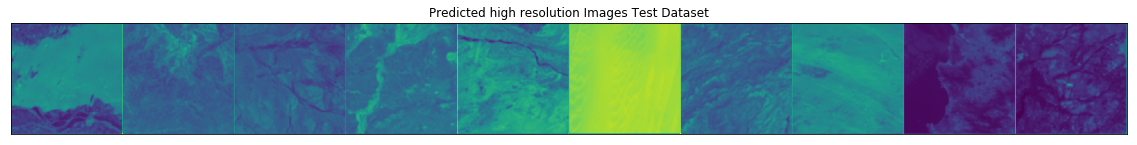

In [42]:
plt.figure(figsize=(20,10))
plt.imshow(np.concatenate(predicted_images[:10], axis=1))
plt.xticks([],[])
plt.yticks([],[])
plt.title('Predicted high resolution Images Test Dataset')

### Saving Predicted Images
Below we are saving all predicted images as png image of unsigned integer of 16 bit so that we can submit it to competition submission.

In [43]:
if not os.path.exists('predicted_images'):
    os.makedirs('predicted_images')
for image_name, image in zip(test_image_sets, predicted_images):
    io.imsave(os.path.join('predicted_images', image_name.split('/')[-1]+'.png'), skimage.img_as_uint(image))

### Zipping Images
Below logic creates zip file out of all predicted high resolution images from test image sets.

In [44]:
print('Archiving: ')
sub_archive = 'submission_resnetv2.zip'
zf = ZipFile(sub_archive, mode='w')
try:
    for img in os.listdir('predicted_images'):
        # ignore the .zip-file itself
        if not img.startswith('imgset'):
            continue
        zf.write('predicted_images/' + img, arcname=img)
        print('*', end='', flush='True')
finally:
    zf.close()

Archiving: 
**************************************************************************************************************************************************************************************************************************************************************************************************

In [45]:
from IPython.display import FileLink
FileLink('submission_resnetv2.zip')

/kaggle/working/submission_resnetv2.zip